# Imports

In [1]:
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
os.path.abspath(os.curdir)
os.chdir("..")
ML_FOLDER_PATH = os.path.abspath(os.curdir)
sys.path.append(ML_FOLDER_PATH)

In [2]:
import src.helpers as hlp
import gc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package words to /Users/jdidio/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Loading data

In [3]:
t_pos = pd.read_table("data/train_pos_full.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_pos['label'] = 1
t_neg = pd.read_table("data/train_neg_full.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')
t_neg['label'] = -1
df = pd.concat((t_pos,t_neg), ignore_index=True)

# Wordcloud of words per label
## Before processing

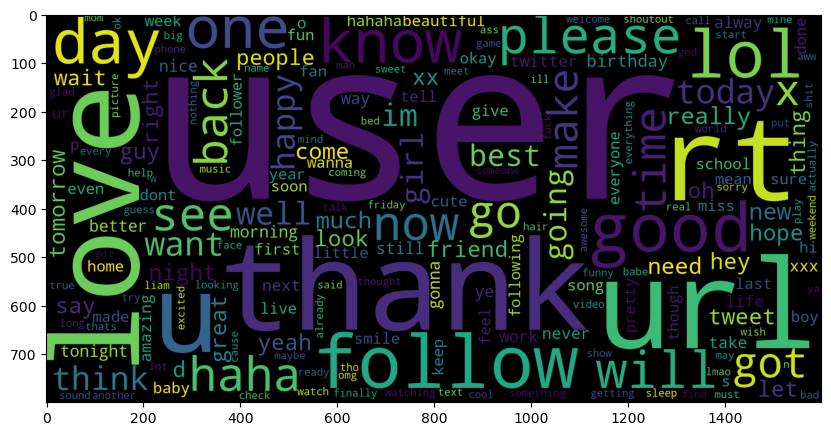

In [4]:
data_pos = df[df['label'] == 1]['tweet']
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 200 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

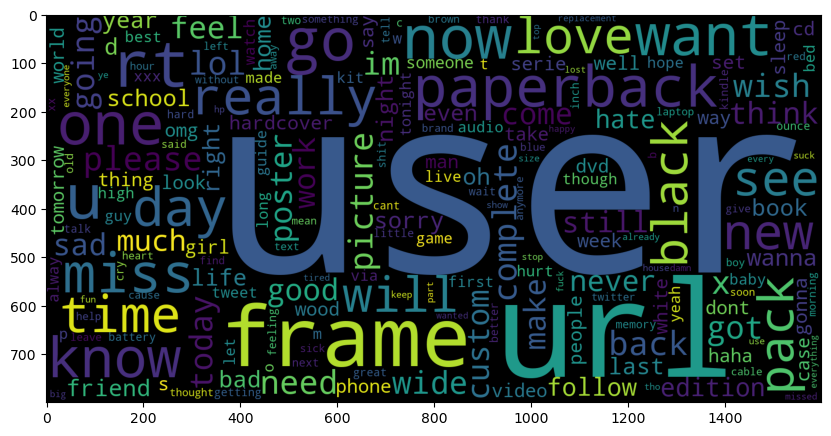

In [5]:
data_neg = df[df['label'] == -1]['tweet']
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 200 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

## After processing

In [4]:
df = hlp.preprocess_data(df)

100%|██████████| 2458295/2458295 [00:34<00:00, 71308.59it/s]


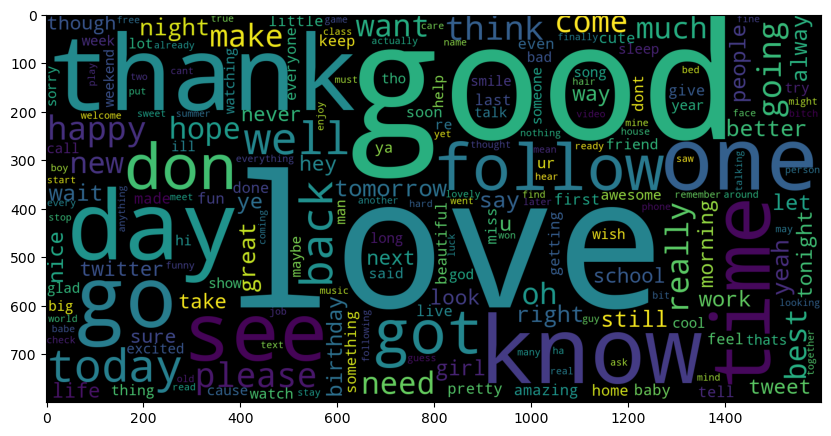

In [11]:
data_pos = df[df['label'] == 1]['tweet']
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 200 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

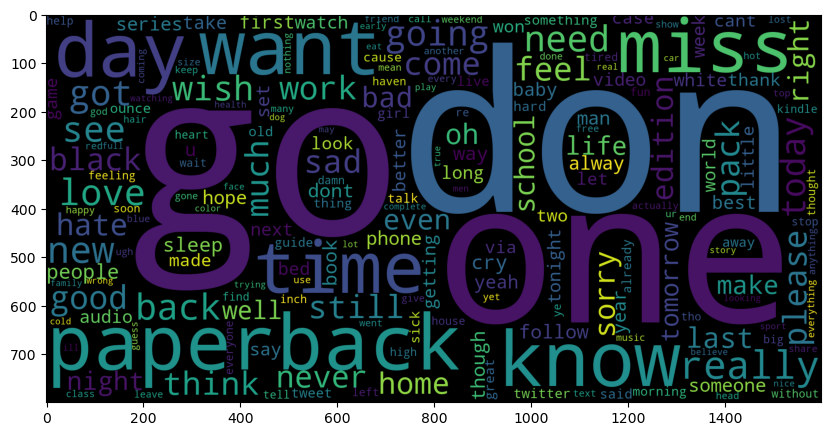

In [12]:
data_neg = df[df['label'] == -1]['tweet']
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 200 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [13]:
del data_neg
del data_pos
gc.collect()

20

# Preparing testing and validation sets

In [5]:
X = df.tweet
y = df.label

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.1, random_state =26105111)

# TF-IDF

In [7]:
vectoriser = TfidfVectorizer(ngram_range=(1,3)) #Tokenized here
vectoriser.fit(X_train)

TfidfVectorizer(ngram_range=(1, 3))

In [8]:
X_train = vectoriser.transform(X_train)
X_val = vectoriser.transform(X_val)

In [9]:
print("Training set shape: ", X_train.shape)
print("Validation set shape: ", X_val.shape)

Training set shape:  (1639728, 7476403)
Validation set shape:  (182192, 7476403)


# Bernoulli naive bayes

In [10]:
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(X_train, y_train)

BernoulliNB()

In [11]:
print(f'BNB training accuracy = {BNB.score(X_train, y_train):.4f}')
print(f'BNB val accuracy = {BNB.score(X_val, y_val):.4f}')

BNB training accuracy = 0.8862
BNB val accuracy = 0.7481


# Linear SVM

In [12]:
from sklearn.svm import LinearSVC
LSVC = LinearSVC(verbose=1)
LSVC.fit(X_train, y_train)

[LibLinear].....*
optimization finished, #iter = 51
Objective value = -468635.934052
nSV = 1345321


LinearSVC(verbose=1)

In [13]:
print(f'SVM training accuracy = {LSVC.score(X_train, y_train):.4f}')
print(f'SVM val accuracy = {LSVC.score(X_val, y_val):.4f}')

SVM training accuracy = 0.9763
SVM val accuracy = 0.7800


# Multinomial NB

In [13]:
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

MultinomialNB()

In [14]:
print(f'MNB training accuracy = {MNB.score(X_train, y_train):.4f}')
print(f'MNB val accuracy = {MNB.score(X_val, y_val):.4f}')

MNB training accuracy = 0.9127
MNB val accuracy = 0.7622


# Prediction on test set

In [ ]:
# Load data
test_df = pd.read_table("data/test_data.txt", header=None, names=['tweet'], dtype=str,on_bad_lines='skip')

# Processing
test_df['tweet'] = test_df['tweet'].apply(lambda x: hlp.remove_stopwords(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x: hlp.remove_punct(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x: hlp.add_space(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x: hlp.remove_white_space(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x: hlp.remove_words_digits(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x: hlp.to_lower(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x: hlp.remove_specific_words(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x: hlp.remove_repeating_char(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x: hlp.lemmatize(x))

In [ ]:
# TF-IDF transform
X_test = vectoriser.transform(test_df.tweet)
X_test.shape

(10000, 4852241)

In [ ]:
pred = LSVC.predict(X_test)

In [ ]:
pred = pd.DataFrame(pred)
pred.index += 1
pred.to_csv('data/pred.csv', header='Prediction')